# Kinship Recognition

Kinship Recognition is an emerging task in Computer Vision that aims to find out if there is a kinship relationship between certain subjects through the images of their faces. The areas of application of kinship verification include **annotating images**, **organizing family albums**, **forensic investigation**, **surveillance**, and more. However, verifying kinship through facial images is challenging as such images contain high intra-variances, which vary by age, gender and other biological characteristics that are often not discriminable by the human eye. Over the years, many more and more effective methods have been developed to solve the problem.

This notebook deals with the recognition of kinship through **neural networks**, in particular using **Siamese Networks**. You can choose to use two main approaches to solve the problem: the first approach uses a **naive** Siamese network, while the second approach uses the **transfer-learning** technique to import **pre-trained networks** such as **DenseNet** and **ResNet**.

# Import Google Drive

Google Drive is imported because the "train.zip" and "test.zip" files are loaded on the drive, in the "ComputerVisionProject" folder

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [2]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualisation
import matplotlib.pyplot as plt

# Fastai 
from fastai.vision import *
from fastai.vision.models import *

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets as dset

from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchvision.models import *
from torchvision.datasets import ImageFolder
from torch.autograd import Variable

# TorchVision models
import torchvision.models as models

from pathlib import Path
import sys

from glob import glob
from PIL import Image

# Random
np.random.seed(42)

In [3]:
# The train.zip file is unzipped in the (local) "train" folder
!unzip "/content/drive/MyDrive/ComputerVisionProject/kinship-dataset/train.zip" -d "train"

Output streaming troncato alle ultime 5000 righe.
  inflating: train/F0099/MID1/P11523_face3.jpg  
  inflating: train/F0099/MID1/P11536_face2.jpg  
  inflating: train/F0099/MID1/P01025_face1.jpg  
  inflating: train/F0099/MID1/P11539_face1.jpg  
  inflating: train/F0099/MID1/P01021_face1.jpg  
  inflating: train/F0099/MID1/P01026_face1.jpg  
  inflating: train/F0099/MID1/P11519_face3.jpg  
  inflating: train/F0099/MID1/P11535_face2.jpg  
  inflating: train/F0099/MID1/P01027_face1.jpg  
  inflating: train/F0099/MID1/P11518_face2.jpg  
  inflating: train/F0099/MID1/P11520_face3.jpg  
  inflating: train/F0099/MID6/P11523_face2.jpg  
  inflating: train/F0099/MID6/P11518_face4.jpg  
  inflating: train/F0099/MID6/P11522_face4.jpg  
  inflating: train/F0099/MID6/P11519_face2.jpg  
  inflating: train/F0099/MID6/P11539_face2.jpg  
  inflating: train/F0099/MID3/P01019_face3.jpg  
  inflating: train/F0099/MID3/P01021_face3.jpg  
  inflating: train/F0099/MID3/P11518_face3.jpg  
  inflating: train/

In [9]:
all_images = glob("train/*/*/*.jpg")
print("Total number of images: ", len(all_images))
print("Example of image path: ",all_images[0])

Total number of images:  12379
Example of image path:  train/F0188/MID2/P02013_face1.jpg


# Train-Validation Split

The images of families starting with "F09" are used as validation set.

In the "train" variable, the training data are organized in pairs (photo1, photo2) depending on whether there is a kinship relationship between photo1 and photo2, which can be obtained from the end "train_relationship.csv" (example of train element: ('F0002 / MID1', 'F0002 / MID3 '))

Total train pairs: 3066
Total val pairs: 296

Per fare ciò:
* All images are recovered (all_images = glob("train/*/*/*.jpg")).
* The images are splitted into train_images and val_images.
* A dictionary is created in which each member of a family is related to his photos (a person has multiple related photos).
* Get all the "single people" (identified by (Fxx / MIDx).
* The pairs of people are created based on the relationships present in the "train_relationship.csv" file (using the "zip" command you can obtain the pairs (relationships.p1.values, relationships.p2.values), that is, pairs of the type (F0001 / MID1, F0001 / MID3)).
* Finally, "train people" and "validation people" are created, always following the logic that F09xx families are used for validation.

In [7]:
from collections import defaultdict

#F09xx are used for validation.
val_families = "F09"

#An example of data:"train/F00002/MID1/P0001_face1.jpg"
all_images = glob("train/*/*/*.jpg")

train_images = [x for x in all_images if val_families not in x]
val_images = [x for x in all_images if val_families in x]

#Put the link of each picture under the keyword of a person such as "F0002 / MID1"
"""
Create a dictionary (train_person_to_images_map and val_person_to_images_map) in which each person (identified by "Family/Member/photo1.jpg") is related to the path of his photos (there are multiple photos for each person)
Example: {'F0452/MID2': ['train/F0452/MID2/P04774_face2.jpg', 'train/F0452/MID2/P04773_face2.jpg', 'train/F0452/MID2/P04771_face1.jpg']}
(The person 'F0452/MID2' (of the family 0452, the member MID2, has 3 faces))
"""
train_person_to_images_map = defaultdict(list)
for x in train_images:
    train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

val_person_to_images_map = defaultdict(list)
for x in val_images:
    val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

# Obtain all the "single people" (identified by "Fxxx/MIDx")
people = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in all_images]
relationships = pd.read_csv("/content/drive/MyDrive/ComputerVisionProject/kinship-dataset/train_relationships.csv")

#For a List like[p1 p2], "zip" command can return a result like [(p1[0],p2[0]),(p1[1],p2[1]),...]
relationships = list(zip(relationships.p1.values, relationships.p2.values))
print("Total relationships pairs: ",len(relationships))
#filter unused relationships (from 3598 samplex to 3362)
relationships = [x for x in relationships if x[0] in people and x[1] in people]
print("Filtered relationships pairs: ",len(relationships))


train = [x for x in relationships if val_families not in x[0]]
val = [x for x in relationships if val_families in x[0]]

print("Example of train pair: ", train[0])
print("Total train pairs:", len(train))    
print("Total val pairs:", len(val)) 

Total relationships pairs:  3598
Filtered relationships pairs:  3362
Example of train pair:  ('F0002/MID1', 'F0002/MID3')
Total train pairs: 3066
Total val pairs: 296


# Obtain the training dataset and validation dataset

This class allows you to create the dataset. To create the dataset it is necessary to have **positive examples** (people who are in relationship) and **negative examples** (people who are not in relationship).
This class receives as input:
1. The folder containing the train data ("train/").
2. The variable that contains the pairs of people who are in a kinship relationship ("train" variable) (e.g. (train[0] = 'F0002 / MID1', 'F0002 / MID3')).
3. The type of transformation to be applied to the images .

That are the operation we need to do:
* Retrieve the information and the MULTIPLE paths of the first imagine of the pair (img_info='F0002/MID1') (img_path = train/F0002/MID1/*.jpg).
* A photo of the first individual is obtained randomly among those of the paths (from train/F0002/MID1/*, we obtain train/F0002/MID1/face1.jpg).
* Get all people who are related to first individual (each person has multiple people related to it).
* A second person is randomly chosen from among the candidates related to first individual or randomly choosed non-related person (in order to obtain positive and negative samples).
* If we have to choose positive example, a random person is chosen from related relationships of first person.
* If we have to choose negative example, a random person is chosen from the dataset. If we (unforunatly) choose a person who is related to the first one, randomly choose another person.

* Finally, open the two photos (with Image.open (img0_path)) and transform the images


THIS PROCESS CAN BE OPTIMIZED BY CHOSING ALL THE TRAIN PAIRS AND THEN ADD SOME NEGATIVE SAMPLES


In [18]:
import random

class trainingDataset(Dataset):#Get two images and whether they are related.
    
    def __init__(self,imageFolderDataset, relationships, transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.relationships = relationships #choose either train or val dataset to use
        self.transform = transform
        
    def __getitem__(self,index):
        # For each relationship in the "train" variable, the first image comes from first row, 
        # and the second is either specially choosed related person or randomly choosed non-related person (in order to have positive and negative samples)
        img0_info = self.relationships[index][0]
        img0_path = glob("train/"+img0_info+"/*.jpg")
        img0_path = random.choice(img0_path) #chose randomically a photo of the individual
        
        # Found all candidates related to person in img0
        # candidate_relationship contains the value of self.relationship (that is the train or val variables,
        # so candidate_relationship = (img0_info, 'Fxxx/MIDx') OR ('Fxxx/MIDx', img0_info))
        candidate_relationship = [x for x in self.relationships if x[0]==img0_info or x[1]==img0_info] 

        # Randomly choose whether to use a positive (1) or a negative (0) example
        if candidate_relationship==[]: # in this case, this should never happen.
            choose_positive_example = 0
        else:
            # Choose randomicaly to have positive or negative example: 1 means related, and 0 means non-related.
            choose_positive_example = random.randint(0,1) 

        # If we have to choose positive example, we get the second person from related relationship
        if choose_positive_example==1:
            img1_info = random.choice(candidate_relationship)#choose the second person from related relationships
            # remember that candidate_relationship = (img0_info, 'Fxxx/MIDx') OR ('Fxxx/MIDx', img0_info)),
            # so img1 is the element of the tuple that is not img0_info 
            if img1_info[0] != img0_info:
                img1_info = img1_info[0]
            else:
                img1_info=img1_info[1]

            #randomly choose a img of second person
            img1_path = glob("train/"+img1_info+"/*.jpg")
            img1_path = random.choice(img1_path)

        # In case we have to choose negative sample, we get the second person randomicaly (0 means non-related)
        else:
            randChoose = True #in case the random chosen person is related to first person
            while randChoose:
                img1_path = random.choice(self.imageFolderDataset.imgs)[0]
                img1_info = img1_path.split("/")[-3] + "/" + img1_path.split("/")[-2]
                randChoose = False
                #if we (unforunatly) choose a person who is related to the first one, randomly choose another person
                for x in candidate_relationship:
                    if x[0]==img1_info or x[1]==img1_info:
                        randChoose = True
                        break

        # Now we have two images (they are related or not)
        img0 = Image.open(img0_path)
        img1 = Image.open(img1_path)
        
        # Transform images
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        # The returned data from dataloader is img=[batch_size,channels,width,length], should_get_same_class=[batch_size,label]
        return img0, img1 , choose_positive_example 
    
    def __len__(self):
        return len(self.relationships)#essential for choose the num of data in one epoch


## Create the training and validation data
Images are transformed using the following transformation:

transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE))transforms.ToTensor()]))

So, they are resized to a size of 100x100, and then they are transformed into tensors.

img0 = Image.open(img0_path);  img0 = self.transform(img0))

In [19]:
folder_dataset = dset.ImageFolder(root='train/')
BATCH_SIZE=64
IMG_SIZE=100

#Training set and training loader
trainset = trainingDataset(imageFolderDataset=folder_dataset,
                                        relationships=train,
                                        transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
trainloader = DataLoader(trainset,
                        shuffle=True,#whether randomly shuffle data in each epoch, but cannot let data in one batch in order.
                        num_workers=8,
                        batch_size=BATCH_SIZE)


#Validation set and Validation loader
valset = trainingDataset(imageFolderDataset=folder_dataset,
                                        relationships=val,
                                        transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
valloader = DataLoader(valset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [37]:
len(trainset)

3066

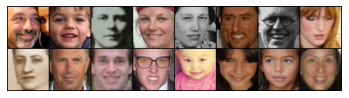

[0 1 1 1 0 0 0 1]


In [21]:
# only for visualize data in dataloader, it won't matters if you delete this block.

def imshow(img,text=None,should_save=False):#for showing the data loaded to dataloader
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):# for showing loss value changed with iter
    plt.plot(iteration,loss)
    plt.show()


vis_dataloader = DataLoader(trainset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

# Siamese Network

Four types of Siamese Networks are presented:
* SiameseNetwork_Naive
* SiameseNetwork_DenseNet
* SiameseNetwork_VGG
* SiameseNetwork_ResNet

Process applied by all implementations:

1. Receive two images as input
2. Apply convolution to both (
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1))
    )
3. The outputs are concatenated (torch.cat((output1, output2),1))
4. Give the concatenated output to the classifier

In [26]:
#10 epoche ci mette 2 min, 100 epoche ci mette 20 minuti circa
class SiameseNetwork_Naive(nn.Module):
    def __init__(self):
        super(SiameseNetwork_Naive, self).__init__()
        
        model = nn.Sequential(
            nn.ReflectionPad2d((1,1,1,1)),
            nn.Conv2d(3,64,kernel_size=(3,3), stride=(1,1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            nn.ReflectionPad2d((1,1,1,1)),
            nn.Conv2d(64,32,kernel_size=(3,3), stride=(1,1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

            nn.ReflectionPad2d((1,1,1,1)),
            nn.Conv2d(32,8,kernel_size=(3,3), stride=(1,1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           )
        
        self.cnn1 = torch.nn.Sequential(*(list(model.children())[:-1]))


        model.classifier = nn.Sequential(
            nn.Linear(in_features=160000, out_features=500, bias=True),
            nn.Linear(in_features=500, out_features=500, bias=True),
            nn.Linear(in_features=500, out_features=2, bias=True)
        )
        self.fc = model.classifier
        
        
    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)
        
        output = torch.cat((output1, output2),1)
        #print(output.shape) #è l'output che deve aver il primo fc
        output = self.fc(output)
        return output

In [27]:
#10 epoche ci mette 6 min, 100 epoche ci mette 1 ora circa
class SiameseNetwork_DenseNet(nn.Module):
    def __init__(self):
        super(SiameseNetwork_DenseNet, self).__init__()
        
        
        model = models.densenet161(pretrained=True) 

        #Freezing tutti i layers
        for param in model.parameters():
          param.require_grad = False

        #Estrazione blocco convoluzionale
        self.cnn1 = torch.nn.Sequential(*(list(model.children())[:-1]))

        #Aggiunta nuovi layers pienamente connessi per classificazione 
        model.classifier = nn.Sequential(
            nn.Linear(39744, 460),
            nn.ReLU(),
            nn.Linear(460, 230),  
            nn.ReLU(),     
            nn.Linear(230, 2)              
        )

        self.fc = model.classifier 
        


    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)
        
        output = torch.cat((output1, output2),1)
        #print(output.shape) #è l'output che deve aver il primo fc
        output = self.fc(output)
        return output

In [28]:
#10 epoche in 4,29 min, 100 epoche in circa 45 min
class SiameseNetwork_VGG(nn.Module):
    def __init__(self):
        super(SiameseNetwork_VGG, self).__init__()
        
        model = models.vgg19(pretrained=True) #Carico VGGFace19 già allenata
        #Freezing tutti i layers
        for param in model.parameters():
          param.require_grad = False

        #Estrazione blocco convoluzionale
        self.cnn1 = torch.nn.Sequential(*(list(model.children())[:-1]))

        #Aggiungo nuovi layers pienamente connessi
        model.classifier = nn.Sequential(
            nn.Linear(50176, 460),
            nn.ReLU(),
            nn.Linear(460, 230),  
            nn.ReLU(),     
            nn.Linear(230, 2)              
        )

        self.fc = model.classifier 
        


    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)
        
        output = torch.cat((output1, output2),1)
        #print(output.shape) #è l'output che deve aver il primo fc
        output = self.fc(output)
        return output

In [29]:
class SiameseNetwork_ResNet(nn.Module):
    def __init__(self):
        super(SiameseNetwork_ResNet, self).__init__()
        
        model = models.resnet101(pretrained=True) #Carico ResNet già addestrata
        #Freezing tutti i layers
        for param in model.parameters():
          param.require_grad = False

        #Estrazione blocco convoluzionale
        self.cnn1 = torch.nn.Sequential(*(list(model.children())[:-1]))

        #Aggiungo nuovi layers pienamente connessi
        model.classifier = nn.Sequential(
            nn.Linear(4096,460),
            nn.ReLU(),
            nn.Linear(460, 230),  
            nn.ReLU(),     
            nn.Linear(230, 2)              
        )

        self.fc = model.classifier 
        


    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)
        
        output = torch.cat((output1, output2),1)
        #print(output.shape) #è l'output che deve aver il primo fc
        output = self.fc(output)
        return output

# Network creation

Here you can chose the network you want by changing the Siamese Network


In [31]:
#Here you can chose the network you want by changing the Siamese Network
net = SiameseNetwork_ResNet().cuda()
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


print(net.eval())

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

SiameseNetwork_ResNet(
  (cnn1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

#TRAINING PHASE

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

BATCH_SIZE=64
NUMBER_EPOCHS=100
epoch_accuracies = np.array([])

for epoch in range(0,NUMBER_EPOCHS):
    print("Epoch：", epoch, " start.")
    for i, data in enumerate(trainloader,0):
        img0, img1 , labels = data #img=tensor[batch_size,channels,width,length], label=tensor[batch_size,label]
        img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()#move to GPU
        #print("epoch：", epoch, "No." , i, "th inputs", img0.data.size(), "labels", labels.data.size())
        optimizer.zero_grad()#clear the calculated grad in previous batch
        outputs = net(img0,img1)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        if i %10 == 0 :#show changes of loss value after each 10 batches
            #print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss.item())
    
    #test the network after finish each epoch, to have a brief training result.
    correct_val = 0
    total_val = 0
    with torch.no_grad():#essential for testing!!!!
        for data in valloader:
            img0, img1 , labels = data
            img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
            outputs = net(img0,img1)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    accuracy = 100 * correct_val / total_val
    epoch_accuracies = np.append(epoch_accuracies, accuracy)

    print('Accuracy of the network on the', total_val, 'val pairs in',val_families, ': %d %%' % (100 * correct_val / total_val))
    show_plot(counter,loss_history)

best_accuracy = np.amax(epoch_accuracies)
best_epoch = epoch_accuracies.argmax()
print('END TRAINING: BEST EPOCH: ', best_epoch, ' WITH ACCURACY: ', best_accuracy)

Output hidden; open in https://colab.research.google.com to view.

# TESTING

In [ ]:
# Unzip the test faces in the (local) "test" folder
!unzip "/content/drive/MyDrive/ComputerVisionProject/kinship-dataset/test.zip" -d "test"

Output streaming troncato alle ultime 5000 righe.
  inflating: test/face04688.jpg      
  inflating: test/face03972.jpg      
  inflating: test/face02593.jpg      
  inflating: test/face00836.jpg      
  inflating: test/face05284.jpg      
  inflating: test/face03261.jpg      
  inflating: test/face00582.jpg      
  inflating: test/face02696.jpg      
  inflating: test/face05325.jpg      
  inflating: test/face04973.jpg      
  inflating: test/face02902.jpg      
  inflating: test/face06245.jpg      
  inflating: test/face00645.jpg      
  inflating: test/face03284.jpg      
  inflating: test/face00188.jpg      
  inflating: test/face05490.jpg      
  inflating: test/face01683.jpg      
  inflating: test/face05566.jpg      
  inflating: test/face03288.jpg      
  inflating: test/face00045.jpg      
  inflating: test/face06050.jpg      
  inflating: test/face02871.jpg      
  inflating: test/face04507.jpg      
  inflating: test/face01597.jpg      
  inflating: test/face03175.jpg      


## Obtain the testing set
Differently from the creation of the training set (where we chose randomicaly from positive or negative samples), here we have to create the tesing-set based on the "sample_submission.csv" files (which contain the testing pairs).

So what we have to do is:
1. Open the *sample_submission.csv* file (that has tuple in the face05508.jpg-face01210.jpg format, the faces.jpg images are on the "test" folder)
2. Get the path of the 2 images
3. Open the image (the path refers to the images in the "test" folder)
4. Apply the transformation

In [ ]:
class testDataset(Dataset): #different from train dataset, because the data organized in submission.csv is different from train.csv
    
    def __init__(self,transform=None):
        self.test_df = pd.read_csv('/content/drive/MyDrive/ComputerVisionProject/kinship-dataset/sample_submission.csv')#pandas用来读取csv文件
        self.transform = transform
        
    def __getitem__(self,index):
        #data in submission.csv:
        #       img_pair               is_related
        #face05508.jpg-face01210.jpg       0
        #face05820.jpg-face03938.jpg       0
        
        img0_path = self.test_df.iloc[index].img_pair.split("-")[0]
        img1_path = self.test_df.iloc[index].img_pair.split("-")[1]
        
        img0 = Image.open('test/'+img0_path)
        img1 = Image.open('test/'+img1_path)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1
    
    def __len__(self):
        return len(self.test_df)

In [ ]:
testset = testDataset(transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
testloader = DataLoader(testset,
                        shuffle=False,
                        num_workers=0,
                        batch_size=1)#Both extra workers and batch size lead to data out of order, the submission.csv will be out of order
#if you have better method, please tell me! thanks a lot!

# Prediction on the test set
The output of the network is a tensor with two values (es tensor([[ 0.5750, -0.4568]])). The first value corresponds to NO, the second corresponds to YES. Thus, taking the index of the greatest value gives the prediction.

Es: tensor([[ 0.5750, -0.4568]]). The greatest value is 0.5750, the index of the value is 0, so the output is 0 (NO KINSHIP)

In [ ]:
#Testing impiega circa 1 minuto (per Naive) e circa 5 minuti (per reti preaddestrate)
test_df = pd.read_csv('/content/drive/MyDrive/ComputerVisionProject/kinship-dataset/sample_submission.csv')#pandas用来读取csv文件
predictions=[]
with torch.no_grad():
    for data in testloader:
        img0, img1 = data
        img0, img1 = img0.cuda(), img1.cuda()
        outputs = net(img0,img1)
        _, predicted = torch.max(outputs, 1)
        predictions = np.concatenate((predictions,predicted.cpu().numpy()),0)#taking care of here, the output data format is important for transfer
        
test_df['is_related'] = predictions
test_df.to_csv("/content/drive/MyDrive/ComputerVisionProject/kinship-dataset/submission_ResNet.csv", index=False)#submission.csv should be placed directly in current fold.
test_df.head(50)#show the result to be committed

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0.0
1,face05750.jpg-face00898.jpg,1.0
2,face05820.jpg-face03938.jpg,1.0
3,face02104.jpg-face01172.jpg,0.0
4,face02428.jpg-face05611.jpg,0.0
5,face01219.jpg-face00274.jpg,0.0
6,face04262.jpg-face00555.jpg,1.0
7,face03697.jpg-face01892.jpg,1.0
8,face03524.jpg-face00319.jpg,1.0
9,face03410.jpg-face05368.jpg,0.0


In [ ]:
# Salvataggio modello
saved_path = "/content/drive/MyDrive/ComputerVisionProject/pretrained_model/ResNet.pth"
torch.save(net, saved_path)